In [20]:
import os
import torch
import torch.nn as nn
import jieba
import nltk
from nltk.corpus import stopwords

from typing import Any


class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size, bias=False)

    def forward(self, center_words):
        embeds = self.embedding(center_words)
        out = self.output(embeds)
        return out


def stat_raw_text(raw_text: list[str]):
    vocab = set(raw_text)
    vocab_size = len(vocab)
    word2idx = {word: i for i, word in enumerate(vocab)}
    idx2word = {i: word for i, word in enumerate(vocab)}
    return vocab, vocab_size, word2idx, idx2word


def make_train_data(raw_text: list[str], window_size: int):
    data = []
    test_data = []
    for i in range(window_size, len(raw_text) - window_size):
        center_word = raw_text[i]
        indices = list(range(i - window_size, i)) + \
            list(range(i + 1, i + window_size + 1))

        test_data.append((center_word, [raw_text[j] for j in indices]))
        for j in indices:
            data.append((center_word, raw_text[j]))
    return data, test_data


def word_to_idx_tensor(word: str, word2idx: dict[str, int]) -> torch.Tensor:
    return torch.tensor([word2idx[word]], dtype=torch.long)


# 下载停用词列表（只需运行一次）
nltk.download('stopwords')

# 获取中文停用词列表
stopwords_list = stopwords.words('chinese')


def read_dir(directory: str):
    stop_words = set(['、', '：', '。', '，', '的', '等', '一', '二',
                     '三', '（', '）', '《', '》', '“', '”', ' ', '\n', '；']+stopwords_list)

    corpus = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if not filepath.endswith('.txt'):
            continue

        with open(filepath, 'r') as f:
            for line in f:
                words = [word for word in jieba.cut(
                    line.strip()) if word not in stop_words]
                corpus.extend(words)
    return corpus


raw_text: list[str] = """We are about to study the idea of a computational process.
    Computational processes are abstract beings that inhabit computers.
    As they evolve, processes manipulate other abstract things called data.
    The evolution of a process is directed by a pattern of rules
    called a program. People create programs to direct processes. In effect,
    we conjure the spirits of the computer with our spells.""".split()  # type: ignore
raw_text = read_dir('./data/')
vocab, vocab_size, word2idx, idx2word = stat_raw_text(raw_text)
data,  test_data = make_train_data(raw_text, 2)

input_indices = torch.tensor([word2idx[center]
                             for center, _ in data], dtype=torch.long)
output_indices = torch.tensor([word2idx[out]
                              for _, out in data], dtype=torch.long)

epochs = 1000
embedding_dim = 500
learning_rate = 0.001
model = SkipGram(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(input_indices)
    loss = criterion(outputs, output_indices)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wuhonglei1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch: 0, Loss: 5.294710636138916
Epoch: 1, Loss: 5.137938022613525
Epoch: 2, Loss: 4.9841508865356445
Epoch: 3, Loss: 4.833621025085449
Epoch: 4, Loss: 4.686643123626709
Epoch: 5, Loss: 4.543515205383301
Epoch: 6, Loss: 4.4045305252075195
Epoch: 7, Loss: 4.269967079162598
Epoch: 8, Loss: 4.14008092880249
Epoch: 9, Loss: 4.015110015869141
Epoch: 10, Loss: 3.8952791690826416
Epoch: 11, Loss: 3.780808210372925
Epoch: 12, Loss: 3.671910047531128
Epoch: 13, Loss: 3.5687806606292725
Epoch: 14, Loss: 3.4715750217437744
Epoch: 15, Loss: 3.380383014678955
Epoch: 16, Loss: 3.2952094078063965
Epoch: 17, Loss: 3.2159650325775146
Epoch: 18, Loss: 3.1424686908721924
Epoch: 19, Loss: 3.07446551322937
Epoch: 20, Loss: 3.01164174079895
Epoch: 21, Loss: 2.953639268875122
Epoch: 22, Loss: 2.9000723361968994
Epoch: 23, Loss: 2.850538492202759
Epoch: 24, Loss: 2.804636240005493
Epoch: 25, Loss: 2.761979103088379
Epoch: 26, Loss: 2.722214460372925
Epoch: 27, Loss: 2.6850295066833496
Epoch: 28, Loss: 2.6501

In [9]:
def same_count(list1, list2):
    count = 0
    for word in list1:
        if word in list2:
            count += 1
    return count


def sorted_list(a):
    return sorted(a, key=lambda x: x[0])


for center_word, contexts in test_data:
    center_word = word_to_idx_tensor(center_word, word2idx)
    output = model(center_word)
    indices = torch.topk(output[0], 4).indices.tolist()
    predicted_words = [idx2word[idx] for idx in indices]
    print(
        f"Context: {sorted(contexts)}, Predicted: {sorted(predicted_words)}, accuracy: {same_count(contexts, predicted_words)}")

Context: ['一门', '人类', '古代', '考古学'], Predicted: ['*', '化学', '方法', '物质'], accuracy: 0
Context: ['一门', '古代', '研究', '社会'], Predicted: ['历史', '古代', '活动', '社会'], accuracy: 2
Context: ['人类', '历史', '研究', '社会'], Predicted: ['*', '人类', '研究', '遗迹'], accuracy: 2
Context: ['人文科学', '人类', '历史', '古代'], Predicted: ['*', '人类', '发展', '经济'], accuracy: 1
Context: ['人文科学', '古代', '社会', '考古'], Predicted: ['*', '人类', '考古学', '记载'], accuracy: 0
Context: ['历史', '学科', '社会', '考古'], Predicted: ['历史', '学科', '社会', '考古'], accuracy: 4
Context: ['人文科学', '介绍', '历史', '学科'], Predicted: ['*', '发掘', '发现', '调查'], accuracy: 0
Context: ['1', '人文科学', '介绍', '考古'], Predicted: ['*', '介绍', '分支', '研究'], accuracy: 1
Context: ['.', '1', '学科', '考古'], Predicted: ['1', '学科', '对象', '研究'], accuracy: 2
Context: ['*', '.', '介绍', '学科'], Predicted: ['*', '.', '介绍', '学科'], accuracy: 4
Context: ['*', '*', '1', '介绍'], Predicted: ['*', '4', '文辞', '误读'], accuracy: 2
Context: ['*', '.', '1', '研究'], Predicted: ['*', '-', '研究', '考古学'], accuracy: 2
Conte

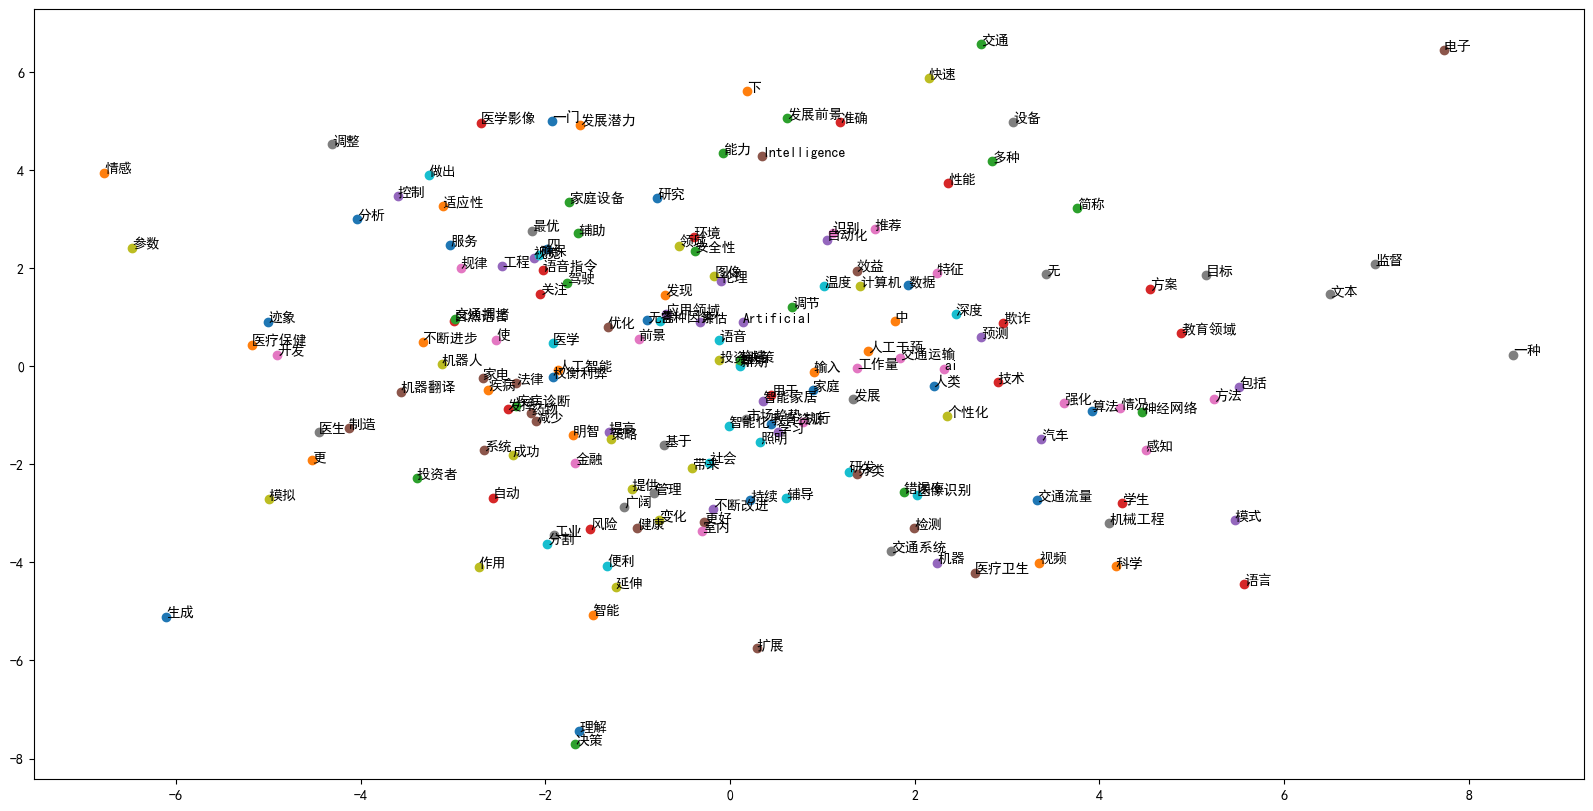

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

# 设置全局字体为 SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

embeddings = model.embedding.weight.data.cpu().numpy()
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
plt.figure(figsize=(20, 10))
for i, word in enumerate(word2idx.keys()):
    x, y = pca_result[i]
    plt.scatter(x, y)
    plt.text(x, y, word)

plt.show()